In [134]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import hopsworks

import warnings
warnings.filterwarnings("ignore")

### <span style='color:#ff5f27'> Imports

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

In [135]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/fingrid from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [136]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store()

2026-01-01 13:48:13,426 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-01 13:48:13,432 INFO: Initializing external client
2026-01-01 13:48:13,434 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-01 13:48:14,756 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


In [137]:
# Retrieve feature groups
energy_fg = fs.get_feature_group(
    name='energy_consumption',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> Feature View Creation and Retrieving </span>

In [138]:
# Select features for training data (no lag features - matching inference)
selected_features = energy_fg.select([
    'consumption_mw', 'date',
    'year', 'month', 'day', 'hour',
    'day_of_week', 'is_weekend', 'week_of_year'
]).join(weather_fg.select_features(), on=['country'])

print("Selected features: temporal + weather (no lags)")

2026-01-01 13:48:16,434 INFO: Using ['temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation'] from feature group `weather_finland` as features for the query. To include primary key and event time use `select_all`.
Selected features: temporal + weather (no lags)


In [139]:
feature_view = fs.get_or_create_feature_view(
    name='energy_consumption_fv',
    description="Temporal and weather features with energy consumption as target (no lag features)",
    version=1,  # Increment version since features changed
    labels=['consumption_mw'],
    query=selected_features,
)

## <span style="color:#ff5f27;">Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [140]:
start_date_test_data = "2025-12-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [141]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Error: Reading data from Hopsworks, using Hopsworks Feature Query Service           


KeyboardInterrupt: 

In [ ]:
X_train

,date,year,month,day,hour,day_of_week,is_weekend,week_of_year,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation
0,2025-07-05 12:48:00+00:00,2025,7,5,12,5,1,27,15.966667,0.4,94.333333,15.466667,21.3,228.333333,1008.700000,610.666667
1,2025-07-05 12:51:00+00:00,2025,7,5,12,5,1,27,15.966667,0.4,94.333333,15.466667,21.3,228.333333,1008.700000,610.666667
2,2025-07-05 12:54:00+00:00,2025,7,5,12,5,1,27,15.966667,0.4,94.333333,15.466667,21.3,228.333333,1008.700000,610.666667
3,2025-07-05 12:57:00+00:00,2025,7,5,12,5,1,27,15.966667,0.4,94.333333,15.466667,21.3,228.333333,1008.700000,610.666667
4,2025-07-05 13:00:00+00:00,2025,7,5,13,5,1,27,15.966667,0.4,94.333333,15.466667,21.3,228.333333,1008.700000,610.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77753,2025-12-14 23:45:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.000000,21.900000,34.9,199.666667,1003.533333,0.000000
77754,2025-12-14 23:48:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.000000,21.900000,34.9,199.666667,1003.533333,0.000000
77755,2025-12-14 23:51:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.000000,21.900000,34.9,199.666667,1003.533333,0.000000
77756,2025-12-14 23:54:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.000000,21.900000,34.9,199.666667,1003.533333,0.000000


In [ ]:
y_train

,consumption_mw
0,8158.2
1,8161.7
2,8183.0
3,8178.9
4,8233.0
...,...
77753,10995.0
77754,10953.0
77755,10946.0
77756,10941.0


In [ ]:
# Drop date column if it exists
columns_to_drop = [col for col in ['date', 'country'] if col in X_train.columns]
X_features = X_train.drop(columns=columns_to_drop)
X_test_features = X_test.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining features: {list(X_features.columns)}")

Dropped columns: ['date']
Remaining features: ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation']


## <span style="color:#ff5f27;">Add Cyclic Features for Temporal Variables</span>

Convert month, hour, and day_of_week to cyclic features using sine/cosine encoding. This ensures the model understands that December (12) is close to January (1), hour 23 is close to hour 0, etc.

In [ ]:
# Add cyclic encoding for month (12 months in a year)
X_features['month_sin'] = np.sin(2 * np.pi * X_features['month'] / 12)
X_features['month_cos'] = np.cos(2 * np.pi * X_features['month'] / 12)
X_test_features['month_sin'] = np.sin(2 * np.pi * X_test_features['month'] / 12)
X_test_features['month_cos'] = np.cos(2 * np.pi * X_test_features['month'] / 12)

# Add cyclic encoding for hour (24 hours in a day)
X_features['hour_sin'] = np.sin(2 * np.pi * X_features['hour'] / 24)
X_features['hour_cos'] = np.cos(2 * np.pi * X_features['hour'] / 24)
X_test_features['hour_sin'] = np.sin(2 * np.pi * X_test_features['hour'] / 24)
X_test_features['hour_cos'] = np.cos(2 * np.pi * X_test_features['hour'] / 24)

# Add cyclic encoding for day_of_week (7 days in a week)
X_features['day_of_week_sin'] = np.sin(2 * np.pi * X_features['day_of_week'] / 7)
X_features['day_of_week_cos'] = np.cos(2 * np.pi * X_features['day_of_week'] / 7)
X_test_features['day_of_week_sin'] = np.sin(2 * np.pi * X_test_features['day_of_week'] / 7)
X_test_features['day_of_week_cos'] = np.cos(2 * np.pi * X_test_features['day_of_week'] / 7)

# Drop the original cyclic features to avoid confusion
X_features = X_features.drop(columns=['month', 'hour', 'day_of_week'])
X_test_features = X_test_features.drop(columns=['month', 'hour', 'day_of_week'])

print("Added cyclic features and dropped original month, hour, day_of_week")
print(f"New feature count: {len(X_features.columns)}")
print(f"Features: {list(X_features.columns)}")

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=3)`.

---

## <span style="color:#ff5f27;">Modeling</span>

We will train a regression model to predict energy consumption using our weather and temporal features

In [ ]:
# Handle any missing values by filling with forward fill then backward fill
X_features = X_features.ffill().bfill()
X_test_features = X_test_features.ffill().bfill()

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating metrics
mae = mean_absolute_error(y_test.iloc[:,0], y_pred)
print("MAE:", mae)

mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R²:", r2)

MAE: 1379.4832851180813
MSE: 3928714.034380925
RMSE: 1982.0983917003023
R²: -2.687551669567593


In [ ]:
# Create dataframe with predictions and dates
df = y_test.copy()
df['predicted_consumption'] = y_pred
df['date'] = X_test['date'].values
df = df.sort_values(by=['date'])
df.head()

,consumption_mw,predicted_consumption,date
77758,10890.0,9961.733398,2025-12-15 00:00:00+00:00
77759,10864.0,9961.733398,2025-12-15 00:03:00+00:00
77760,10871.0,9961.733398,2025-12-15 00:06:00+00:00
77761,10877.0,9961.733398,2025-12-15 00:09:00+00:00
77762,10912.0,9961.733398,2025-12-15 00:12:00+00:00


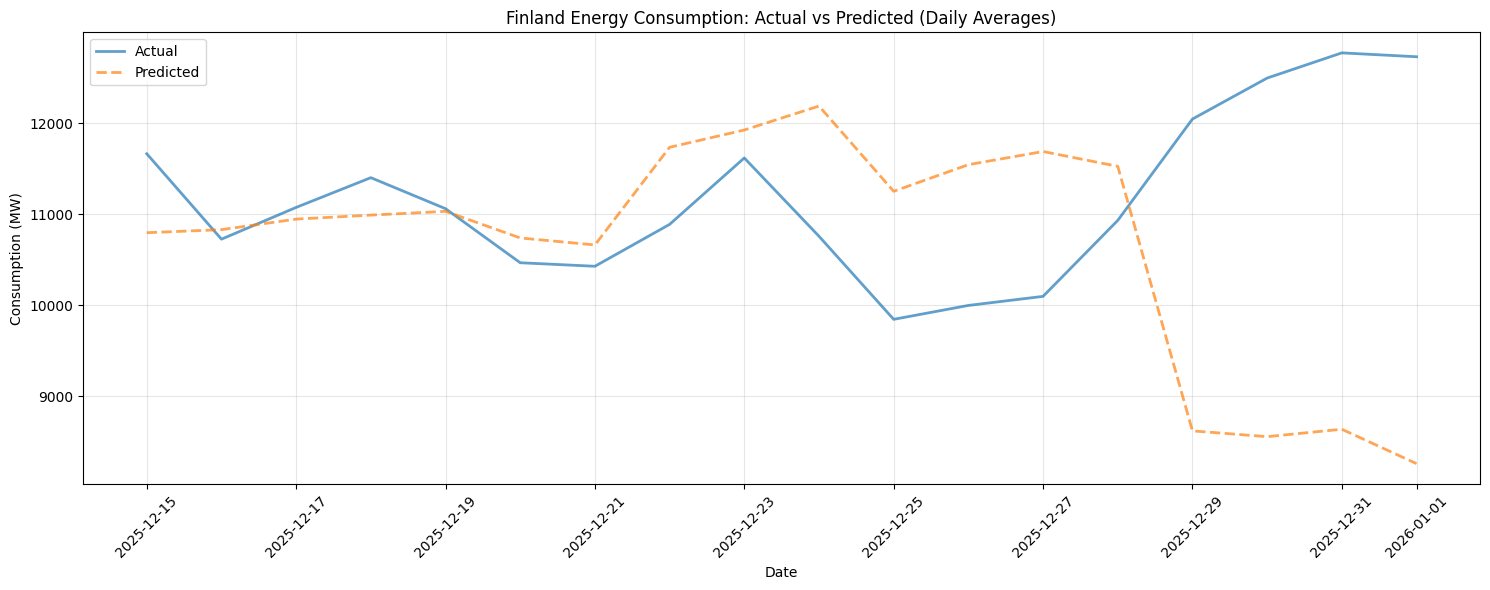

Original samples: 8392, Daily averages shown: 18


In [ ]:
# Plot predictions vs actual (resampled to daily averages for clarity)
# Resample to daily averages to make the plot readable
df['date'] = pd.to_datetime(df['date'])
df_daily = df.set_index('date').resample('D').mean().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(df_daily['date'], df_daily['consumption_mw'], label='Actual', linewidth=2, alpha=0.7)
plt.plot(df_daily['date'], df_daily['predicted_consumption'], label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption: Actual vs Predicted (Daily Averages)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Original samples: {len(df)}, Daily averages shown: {len(df_daily)}")

In [ ]:
# Investigate the drop between samples 6000-8000
print(f"Total test samples: {len(y_test)}")
print(f"\nTest set date range:")
print(f"  Start: {X_test['date'].min()}")
print(f"  End: {X_test['date'].max()}")

if len(y_test) > 8000:
    print(f"\nDates around the drop (samples 5900-6100):")
    print(X_test.iloc[5900:6100:20][['date']])
    
    print(f"\nDates around sample 7000:")
    print(X_test.iloc[6900:7100:20][['date']])
    
    print(f"\nConsumption values around the drop:")
    print(f"  Sample 6000: {y_test.iloc[6000, 0]:.2f} MW")
    print(f"  Sample 7000: {y_test.iloc[7000, 0]:.2f} MW")
    print(f"  Sample 8000: {y_test.iloc[8000, 0]:.2f} MW")
else:
    print(f"\nTest set only has {len(y_test)} samples, not 8000+")
    print("The drop you're seeing might be in the full dataset visualization")

Total test samples: 8392

Test set date range:
  Start: 2025-12-15 00:00:00+00:00
  End: 2026-01-01 11:45:00+00:00

Dates around the drop (samples 5900-6100):
                            date
83658  2025-12-27 07:09:00+00:00
83678  2025-12-27 08:09:00+00:00
83698  2025-12-27 09:09:00+00:00
83718  2025-12-27 10:09:00+00:00
83738  2025-12-27 11:09:00+00:00
83758  2025-12-27 12:09:00+00:00
83778  2025-12-27 13:12:00+00:00
83798  2025-12-27 14:12:00+00:00
83818  2025-12-27 15:12:00+00:00
83838  2025-12-27 16:12:00+00:00

Dates around sample 7000:
                            date
84658  2025-12-29 09:12:00+00:00
84678  2025-12-29 10:12:00+00:00
84698  2025-12-29 11:12:00+00:00
84718  2025-12-29 12:12:00+00:00
84738  2025-12-29 13:12:00+00:00
84758  2025-12-29 14:12:00+00:00
84778  2025-12-29 15:12:00+00:00
84798  2025-12-29 16:12:00+00:00
84818  2025-12-29 17:12:00+00:00
84838  2025-12-29 18:12:00+00:00

Consumption values around the drop:
  Sample 6000: 10341.00 MW
  Sample 7000: 12838.00 

In [144]:
# Detailed analysis of the prediction failure around New Year's
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')

# Focus on Dec 28 - Jan 1
new_years = df_sorted[df_sorted['date'] >= '2025-12-28']

print("New Year's Period Analysis (Dec 28 - Jan 1):")
print("=" * 80)
print(f"\nActual consumption:")
print(f"  Min: {new_years['consumption_mw'].min():.0f} MW")
print(f"  Max: {new_years['consumption_mw'].max():.0f} MW")
print(f"  Mean: {new_years['consumption_mw'].mean():.0f} MW")

print(f"\nPredicted consumption:")
print(f"  Min: {new_years['predicted_consumption'].min():.0f} MW")
print(f"  Max: {new_years['predicted_consumption'].max():.0f} MW")
print(f"  Mean: {new_years['predicted_consumption'].mean():.0f} MW")

print(f"\nError:")
print(f"  MAE: {mean_absolute_error(new_years['consumption_mw'], new_years['predicted_consumption']):.0f} MW")
print(f"  Mean error: {(new_years['consumption_mw'] - new_years['predicted_consumption']).mean():.0f} MW")

# Sample some predictions
print("\nSample predictions (last 10 timestamps):")
print(df_sorted[['date', 'consumption_mw', 'predicted_consumption']].tail(10))

New Year's Period Analysis (Dec 28 - Jan 1):

Actual consumption:
  Min: 9718 MW
  Max: 13650 MW
  Mean: 12133 MW

Predicted consumption:
  Min: 7910 MW
  Max: 12161 MW
  Mean: 9215 MW

Error:
  MAE: 3190 MW
  Mean error: 2918 MW

Sample predictions (last 10 timestamps):
                           date  consumption_mw  predicted_consumption
86140 2026-01-01 11:18:00+00:00         13203.0            8365.861328
86141 2026-01-01 11:21:00+00:00         13233.0            8365.861328
86142 2026-01-01 11:24:00+00:00         13224.0            8365.861328
86143 2026-01-01 11:27:00+00:00         13214.0            8365.861328
86144 2026-01-01 11:30:00+00:00         13220.0            8365.861328
86145 2026-01-01 11:33:00+00:00         13247.0            8365.861328
86146 2026-01-01 11:36:00+00:00         13197.0            8365.861328
86147 2026-01-01 11:39:00+00:00         13191.0            8365.861328
86148 2026-01-01 11:42:00+00:00         13233.0            8365.861328
86149 2026-01-01 1

In [145]:
# Check what features look like around New Year's
X_test_with_date = X_test.copy()
X_test_with_date['predicted'] = y_pred
X_test_with_date['actual'] = y_test.values

# Filter for New Year's period
new_years_features = X_test_with_date[X_test_with_date['date'] >= '2025-12-28'].sort_values('date')

print("Feature values during the prediction failure:")
print("=" * 80)
print("\nTemporal features:")
print(new_years_features[['date', 'month', 'day', 'hour', 'day_of_week', 'is_weekend']].describe())

# Check if weather features exist and show them
weather_cols = [col for col in new_years_features.columns if any(w in col.lower() for w in ['temp', 'wind', 'precip', 'pressure'])]
if weather_cols:
    print("\nWeather features statistics:")
    print(new_years_features[weather_cols].describe())
    
print("\nFirst few rows of New Year's period:")
display_cols = ['date', 'hour', 'day', 'actual', 'predicted'] + weather_cols[:3]
print(new_years_features[display_cols].head(20))

Feature values during the prediction failure:

Temporal features:
             month          day         hour  day_of_week   is_weekend
count  2156.000000  2156.000000  2156.000000  2156.000000  2156.000000
mean     10.795918    26.380334    10.833024     2.332096     0.222635
std       3.435194     8.962622     6.897994     2.162560     0.416111
min       1.000000     1.000000     0.000000     0.000000     0.000000
25%      12.000000    28.000000     5.000000     1.000000     0.000000
50%      12.000000    29.000000    10.000000     2.000000     0.000000
75%      12.000000    30.000000    17.000000     3.000000     0.000000
max      12.000000    31.000000    23.000000     6.000000     1.000000

Weather features statistics:
       temperature_2m  precipitation  wind_speed_10m  wind_speed_100m  \
count     2156.000000    2156.000000     2156.000000      2156.000000   
mean        -5.488312       0.097403       20.791095        33.865986   
std          5.031988       0.199472        7.

---

## <span style="color:#ff5f27;">Feature Importance Analysis</span>

In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_features.columns,
    'importance': xgb_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
feature_importance.head(15)

Top 15 Most Important Features:


,feature,importance
6,week_of_year,0.871605
14,shortwave_radiation,0.045477
7,temperature_2m,0.020363
4,day_of_week,0.018736
13,surface_pressure,0.009011
11,wind_speed_100m,0.008027
3,hour,0.007945
12,wind_direction_10m,0.005960
10,wind_speed_10m,0.003564
2,day,0.003147


In [ ]:
# Check correlation between features and target (using cleaned features)
correlations = X_features.corrwith(y_train.iloc[:, 0]).abs().sort_values(ascending=False)
print("Top 20 features by correlation with consumption:")
print(correlations.head(20))

Top 20 features by correlation with consumption:
week_of_year           0.794814
month                  0.773639
temperature_2m         0.742345
cloud_cover            0.268750
wind_speed_10m         0.231331
wind_speed_100m        0.206749
shortwave_radiation    0.185145
surface_pressure       0.113628
wind_direction_10m     0.113223
is_weekend             0.111690
hour                   0.071248
day_of_week            0.069296
precipitation          0.016245
day                    0.003453
year                        NaN
dtype: float64


In [ ]:
# Check all features and their importance
print("All features in the model:")
print(feature_importance)
print(f"\nTotal features: {len(feature_importance)}")

# Identify weather features (assuming they contain 'temp', 'wind', 'precip', 'pressure', 'humidity')
weather_keywords = ['temp', 'wind', 'precip', 'pressure', 'humidity', 'weather']
weather_features = feature_importance[feature_importance['feature'].str.contains('|'.join(weather_keywords), case=False)]
print(f"\nWeather features found: {len(weather_features)}")
if len(weather_features) > 0:
    print("\nWeather feature importance:")
    print(weather_features)

All features in the model:
                feature  importance
6          week_of_year    0.871605
14  shortwave_radiation    0.045477
7        temperature_2m    0.020363
4           day_of_week    0.018736
13     surface_pressure    0.009011
11      wind_speed_100m    0.008027
3                  hour    0.007945
12   wind_direction_10m    0.005960
10       wind_speed_10m    0.003564
2                   day    0.003147
8         precipitation    0.002690
9           cloud_cover    0.002527
1                 month    0.000949
0                  year    0.000000
5            is_weekend    0.000000

Total features: 15

Weather features found: 6

Weather feature importance:
               feature  importance
7       temperature_2m    0.020363
13    surface_pressure    0.009011
11     wind_speed_100m    0.008027
12  wind_direction_10m    0.005960
10      wind_speed_10m    0.003564
8        precipitation    0.002690


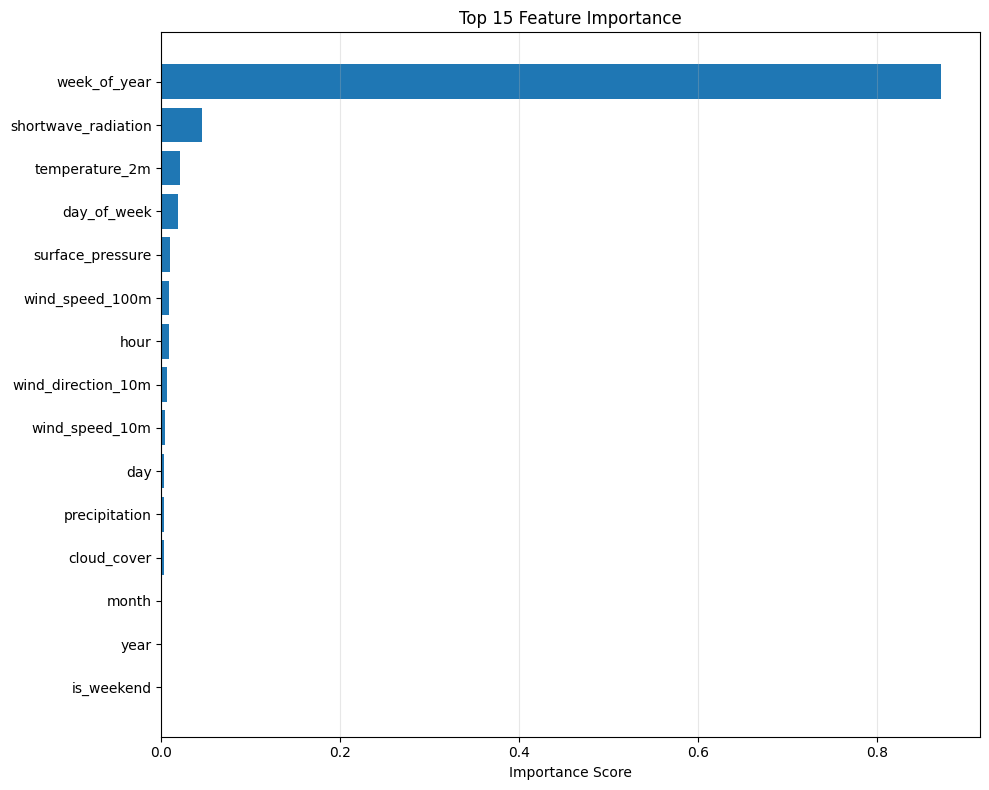

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---

## <span style="color:#ff5f27;">Register Model to Hopsworks</span>

In [ ]:
# Get model registry
mr = project.get_model_registry()

# Create model schema (input/output)
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Register model
energy_model = mr.python.create_model(
    name="energy_consumption_predictor",
    metrics={
        "mae": float(mae),
        "mse": float(mse),
        "rmse": float(rmse),
        "r2": float(r2)
    },
    description="XGBoost model for Finland energy consumption forecasting with weather features",
    input_example=X_train.sample(n=5),
    model_schema=model_schema
)

# Save model to registry
import os
model_dir = "energy_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
import joblib
joblib.dump(xgb_regressor, f"{model_dir}/energy_consumption_predictor.pkl")

energy_model.save(model_dir)
print(f"Model registered successfully!")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\notebooks\fingrid\energy_model/energy_consumption_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\notebooks\fingrid\input_example.json: 0.000%|     …

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\notebooks\fingrid\model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286359/models/energy_consumption_predictor/6
Model registered successfully!
